In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
torch.cuda.is_available()
torch.__path__
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

In [2]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,1,1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels,3,1,1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [58]:
ResConv = ResidualConvBlock(1,1)

torch.Size([32, 32])


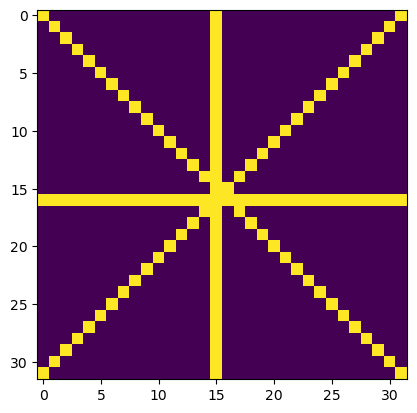

In [81]:
x = torch.eye(32)
# x = torch.stack((x,x/2,x/3), axis=0)
# x = x.reshape(3,16,16)
print(x.shape)
x[int(x.shape[0]/2),:] = 1
x[:, int(x.shape[1]/2)-1] = 1
np.fill_diagonal(x.numpy()[:,::-1], 1)
# plt.imshow(x.permute(1,2,0))
plt.imshow(x)
x = np.expand_dims(x, axis=0)
x = torch.Tensor(x)

In [99]:
ResConv_out = ResConv.forward(torch.stack((x,x/2), axis=0))
ResConv_out.shape

torch.Size([2, 1, 32, 32])

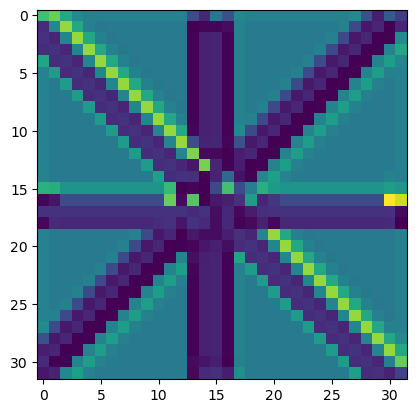

In [100]:
plt.imshow(ResConv_out[0][0].detach())
# plt.imshow(ResConv_out[0].permute(1,2,0).detach())
plt.show()
# plt.imshow(ResConv_out[1].permute(1,2,0).detach())
# plt.imshow(ResConv_out[1][0].detach())
# plt.show()

In [101]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [131]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        print("x.shape =", x.shape)
        print("skip.shape =", skip.shape)
        x = torch.cat((x, skip), 1)
        # print(x)
        x = self.model(x)
        # print(x)
        return x

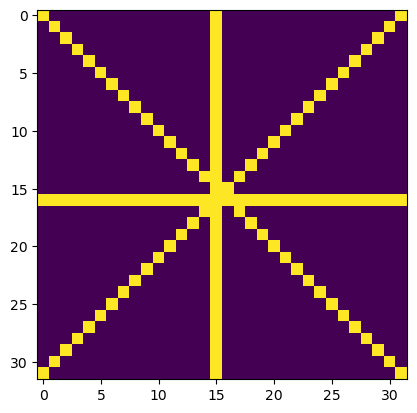

torch.Size([2, 1, 16, 16])


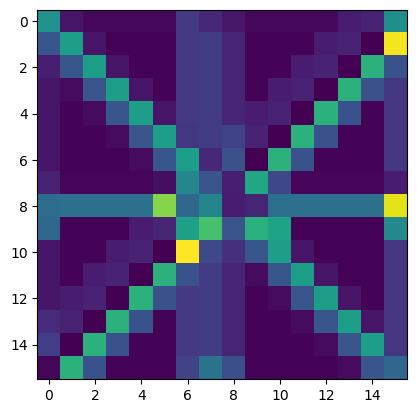

In [134]:
plt.imshow(x[0])
plt.show()
down = UnetDown(1,1).forward(torch.stack((x,x/2), axis=0))
print(down.shape)
plt.imshow(down.detach()[0][0])
plt.show()
# plt.imshow(x[0])
# plt.show()
# plt.imshow(UnetUp(1,1).forward(torch.stack((x,x/2), axis=0), skip=down.detach()))
# plt.show()

In [141]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [1]:
class 动物:
    def __init__(self, 名字):
        self.名字 = 名字
        print("{}诞生！".format(self.名字))
    
    def 呼吸(self):
        print("{}呼吸了一下".format(self.名字))

In [2]:
ZYD = 动物("赵娅迪")

赵娅迪诞生！


In [3]:
ZYD.呼吸()

赵娅迪呼吸了一下


In [4]:
ZYD.名字

'赵娅迪'

In [1]:
from huggingface_hub import notebook_login
notebook_login()
from accelerate import notebook_launcher
import torch
from dataclasses import dataclass
import datasets
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from accelerate import Accelerator, notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from time import sleep
import matplotlib.pyplot as plt
from diffusers import UNet2DModel

@dataclass
class TrainingConfig:
    image_size = 128
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'
    output_dir = "ddpm-butterflies-128"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()


config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split='train')

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

model = UNet2DModel(
    sample_size = config.image_size,
    in_channels = 3,
    out_channels = 3,
    layers_per_block = 2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D',
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = len(train_dataloader) * config.num_epochs,
)


def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    import torch
    import numpy as np
    accelerator = Accelerator(
        mixed_precision = config.mixed_precision,
        gradient_accumulation_steps = config.gradient_accumulation_steps,
        log_with = 'tensorboard',
        project_dir = os.path.join(config.output_dir, 'logs'),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id = config.hub_model_id or Path(config.output_dir).name,
                exist_ok = True,
            ).repo_id
        accelerator.init_trackers('training_example')
    
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler,
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # print(clean_images.device)
            # sleep(1)
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device, dtype=torch.int64
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                # print("loss:", loss)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id = repo_id,
                        folder_path = config.output_dir,
                        commit_message = f'Epoch {epoch}',
                        ignore_patterns=['step_*', 'epoch_*'],                        
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

# args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

device_count = torch.cuda.device_count()
notebook_launcher(train_loop, (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler), num_processes=1)

# test on 21cm dataset

In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
import numpy as np
from accelerate import notebook_launcher
import torch
from dataclasses import dataclass
import datasets
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from accelerate import Accelerator, notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from time import sleep
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
import h5py
from datasets import Dataset

@dataclass
class TrainingConfig:
    image_size = [64,512]
    train_batch_size = 16
    eval_batch_size = 24
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 10
    mixed_precision = 'fp16'
    output_dir = "diffusion21cm"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()
# config.dataset_name = "diffusion21cm"
# dataset = load_dataset(config.dataset_name, split='train')

In [3]:
with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64.h5", 'r') as f:
    print(f.keys())
    print(f['brightness_temp'])
    Tb = f['brightness_temp'][:1000,0,:,:]

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params_seeds', 'redshifts_distances']>
<HDF5 dataset "brightness_temp": shape (30000, 64, 64, 514), type "<f4">


(1000, 64, 514)
<class 'numpy.ndarray'>


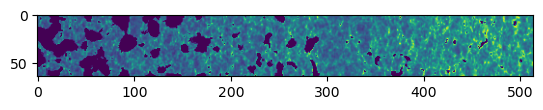

In [4]:
print(Tb.shape)
print(type(Tb))
# plt.imshow(Tb[0])
plt.imshow(Tb[0])

In [5]:
# config.dataset_name = "huggan/smithsonian_butterflies_subset"
# dataset = load_dataset(config.dataset_name, split='train')
# print(dataset.shape)
# print(type(dataset))
# print(dataset)
# print(dataset[0]['image'].convert('RGB'))
# print(np.shape(dataset[0]['image']))
# dataset[0]['image'].convert('RGB')

In [6]:
def load_numpy_dataset(np_array, split='train'):
    assert split in ['train', 'test', 'validation'], "Invalid split name. Use 'train', 'test', or 'validation'."
    dataset = Dataset.from_dict({'image': np_array})
    return dataset
dataset = load_numpy_dataset(Tb)
print(type(dataset))
print(len(dataset))
print(np.shape(dataset))
print(dataset)
print(np.shape(dataset[0]['image']))

<class 'datasets.arrow_dataset.Dataset'>
1000
(1000, 1)
Dataset({
    features: ['image'],
    num_rows: 1000
})
(64, 514)


(64, 514)
0.0 62.48933029174805


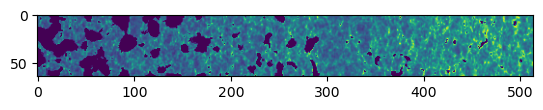

In [7]:
test = np.array(dataset[0]['image'])
print(test.shape)
print(test.min(), test.max())
test = (test-test.min())/(test.max()-test.min())
# plt.imshow((test*255).astype(np.int))
plt.imshow(test)
plt.show()

In [8]:
def normalize(image):
    initial_data = np.array(image)
    data = (initial_data - initial_data.min()) / (initial_data.max()-initial_data.min())
    # data = (normalized_data*255).astype(np.uint8)
    data = Image.fromarray(np.uint8(data*255))
    return data

preprocess = transforms.Compose(
    [
        # normalize(),
        transforms.Resize((config.image_size[0], config.image_size[1])),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transform(examples):
    images = [preprocess(normalize(image)) for image in examples['image']]
    # images = [preprocess(image) for image in examples['image']]
    # print(np.shape(images[0]))
    return {"images": images}

# datasets = transform(Tb)
dataset.set_transform(transform)

In [9]:
dataset[0]['images'].shape

torch.Size([1, 64, 512])

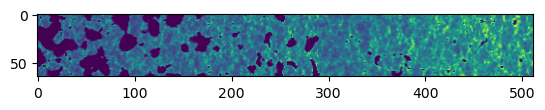

In [10]:
plt.imshow(dataset[0]['images'][0])

In [11]:
# dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [12]:
next(iter(train_dataloader))['images'].shape

torch.Size([16, 1, 64, 512])

In [13]:
model = UNet2DModel(
    sample_size = config.image_size,
    in_channels = 1,
    out_channels = 1,
    layers_per_block = 2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D',
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = len(train_dataloader) * config.num_epochs,
)


def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=12, cols=2)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    import torch
    import numpy as np
    accelerator = Accelerator(
        mixed_precision = config.mixed_precision,
        gradient_accumulation_steps = config.gradient_accumulation_steps,
        log_with = 'tensorboard',
        project_dir = os.path.join(config.output_dir, 'logs'),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id = config.hub_model_id or Path(config.output_dir).name,
                exist_ok = True,
            ).repo_id
        accelerator.init_trackers('training_example')
    
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler,
    )

    global_step = 0
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
    
        
        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # print(clean_images.device)
            # sleep(1)
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device, dtype=torch.int64
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                # print("loss:", loss)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id = repo_id,
                        folder_path = config.output_dir,
                        commit_message = f'Epoch {epoch}',
                        ignore_patterns=['step_*', 'epoch_*'],                        
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)


In [14]:
# args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
device_count = torch.cuda.device_count()
notebook_launcher(train_loop, (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler), num_processes=1)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.


  0%|          | 0/63 [00:00<?, ?it/s]

/scratch/5495298/ipykernel_22069/2220207547.py:3: RuntimeWarning: invalid value encountered in true_divide
  data = (initial_data - initial_data.min()) / (initial_data.max()-initial_data.min())


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1712107271.atl1-1-03-004-33-0.pace.gatech.edu.90591.0:   0%|          | 0.00/25.9k [00:00<…

events.out.tfevents.1712107175.atl1-1-03-004-33-0.pace.gatech.edu.1952.0:   0%|          | 0.00/1.45k [00:00<?…

events.out.tfevents.1712109728.atl1-1-03-004-33-0.pace.gatech.edu.252572.0:   0%|          | 0.00/91.9k [00:00…

events.out.tfevents.1712109230.atl1-1-03-004-33-0.pace.gatech.edu.86105.0:   0%|          | 0.00/53.4k [00:00<…

events.out.tfevents.1712109547.atl1-1-03-004-33-0.pace.gatech.edu.199669.0:   0%|          | 0.00/88.0 [00:00<…

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

events.out.tfevents.1712110827.atl1-1-03-004-33-0.pace.gatech.edu.11893.0:   0%|          | 0.00/78.1k [00:00<…

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/78.1k [00:00<…

0009.png:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/156k [00:00<?…

0019.png:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

0029.png:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/234k [00:00<?…

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/312k [00:00<?…

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1712113010.atl1-1-02-005-35-0.pace.gatech.edu.22069.0:   0%|          | 0.00/390k [00:00<?…

0049.png:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

0044.png:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 